In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import sklearn
from sklearn.linear_model import LinearRegression

In [57]:
water = pd.read_csv(r'C:\Users\jsphh\OneDrive\Documents\Water_Potability\Water_Potability.csv')
#first look at the data
water.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890456,20791.31898,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.05786,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.54173,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.41744,8.059332,356.886136,363.266516,18.436525,100.341674,4.628771,0
4,9.092223,181.101509,17978.98634,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [58]:
water.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [59]:
#data types look good
water.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690300,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833605,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762125,8.114887,359.950170,481.792305,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196010,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [62]:
#It looks like we have missing values. Before we dive into possibly imputing
#for missing values and / or outliers, let's make sure the data we do have is fine.
#First thought: most of these features are lengthy floats and should not have duplicates.
for col in water:
    print(water[col].nunique() / water[col].notnull().sum())

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0006105006105006105


In [ ]:
#We have no categorical values in this dataset, so we need not worry about variation in values that should be equivalent.
#(such as 'M' and 'male')

<AxesSubplot:xlabel='variable', ylabel='value'>

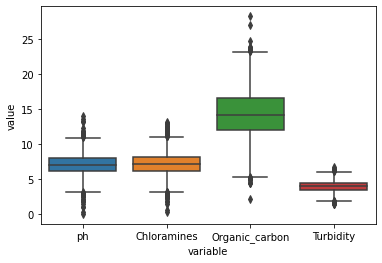

In [63]:
#Next let's get a sense of outliers in this dataset. For the sake of readability, I will group box plots by similar value scale.
box_plot_1 = water[['ph','Chloramines','Organic_carbon','Turbidity']]
sns.boxplot(x="variable",y="value",data=pd.melt(plot_1))

<AxesSubplot:xlabel='variable', ylabel='value'>

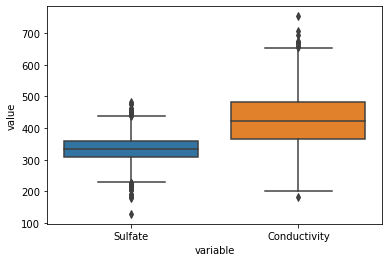

In [64]:
box_plot_2 = water[['Hardness','Sulfate', 'Conductivity']]
sns.boxplot(x='variable',y='value',data=pd.melt(plot_2))

<AxesSubplot:>

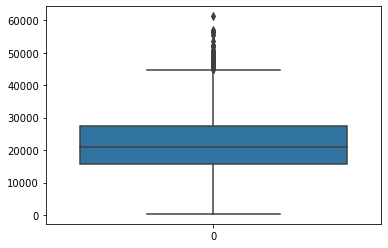

In [65]:
#just solids
sns.boxplot(data=water['Solids'])

In [66]:
#We may have some outliers. Let's investigate
def outlier(data):
    iqr = np.nanpercentile(data,75) - np.nanpercentile(data,25)
    out_high = np.nanpercentile(data,75) + (1.5 * iqr)
    out_low = np.nanpercentile(data,25) - (1.5 * iqr)
    outs = data[(data <= out_low) | (data >= out_high)]
    return len(outs) / len(data.notnull())

for i in water:
    out_percent = outlier(water[i]) * 100
    print(round(out_percent,2),"%")

1.4 %
2.53 %
1.43 %
1.86 %
1.25 %
0.34 %
0.76 %
1.01 %
0.58 %
0.0 %


In [67]:
#At the maximum, outliers represent 2.5% of a feature (Hardness here). We can handle this with 
#flooring / capping imputation: that is, imputing leftward outliers with the 10th percentile value and rightward outliers with
#the 90th percentile.
for col in water:
    for ob in water[col]:
        q1 = water[col].quantile(0.25)
        q3 = water[col].quantile(0.75)
        iqr = q3 - q1
        out_high = q3 + (1.5 * iqr)
        out_low = q1 - (1.5 * iqr)
        water[col] = np.where(water[col] < out_low, water[col].quantile(0.10),water[col])
        water[col] = np.where(water[col] > out_high, water[col].quantile(0.90),water[col])

In [68]:
#Earlier we encountered missing values. Let's investigate that
missing = pd.concat([water.isnull().sum(), 100 * water.isnull().mean()],axis=1)
missing.columns=['count','%']
missing.sort_values(by='%',ascending=False)

,count,%
Sulfate,781,23.840049
ph,491,14.987790
Trihalomethanes,162,4.945055
Hardness,0,0.000000
Solids,0,0.000000
Chloramines,0,0.000000
Conductivity,0,0.000000
Organic_carbon,0,0.000000
Turbidity,0,0.000000
Potability,0,0.000000


In [69]:
#What to do about these missing values? At these proportions, we must consider
#imputing. For trihalomethanes--with a rather low percentage of nulls--
#it makes sense to impute the median.
water['Trihalomethanes'] = water['Trihalomethanes'].fillna(water['Trihalomethanes'].median())

In [70]:
#Now onto ph and Sulfate
water_nonulls = water.dropna()
water_potable = water_nonulls[water_nonulls['Potability'] == 1]
water_notpot = water_nonulls[water_nonulls['Potability'] == 0]

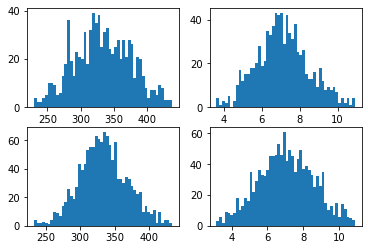

In [71]:
#look at the difference in distributions for the features between water that is potable and water that is not
fig, axs = plt.subplots(2,2)
axs[0,0].hist(water_potable['Sulfate'],bins=50)
axs[0,1].hist(water_potable['ph'],bins=50)
axs[1,0].hist(water_notpot['Sulfate'],bins=50)
axs[1,1].hist(water_notpot['ph'],bins=50)
plt.show()

In [72]:
#Rather than imputing the missing values with the median, it seems a better decision to impute using a predictive model. 
model = LinearRegression()
#split into train and test dataframes, targeting Sulfate. But we cannot use ph (missing values) or Potability (categorical)
water_test = water[water['Sulfate'].isnull() == True]
water_test = water_test.drop('ph',axis=1)
water_test = water_test.drop('Potability',axis=1)
water_train = water[water['Sulfate'].isnull() == False]
water_train = water_train.drop('ph',axis=1)
water_train = water_train.drop('Potability', axis=1)
y = water_train['Sulfate']
# now drop the target from the training set and fit the model
water_train = water_train.drop('Sulfate',axis=1)
model.fit(water_train,y)
# now drop the target from our test set and predict
water_test = water_test.drop('Sulfate',axis=1)
pred = model.predict(water_test)
water_test['Sulfate'] = pred
#now impute our original DataFrame with the predicted values
water['Sulfate'] = water['Sulfate'].fillna(water_test['Sulfate'])

In [73]:
water['Sulfate'].describe()

count    3276.000000
mean      333.915355
std        33.998383
min       229.575561
25%       316.571141
50%       333.836906
75%       350.538503
max       437.647162
Name: Sulfate, dtype: float64

In [74]:
#Now on to ph. Same process as above
lr = LinearRegression()
water_test1 = water[water['ph'].isnull() == True]
water_test1 = water_test1.drop('Potability',axis=1)
water_train1 = water[water['ph'].isnull() == False]
water_train1 = water_train1.drop('Potability',axis=1)
y = water_train1['ph']
water_train1 = water_train1.drop('ph',axis=1)
lr.fit(water_train1,y)
water_test1 = water_test1.drop('ph',axis=1)
pred1 = lr.predict(water_test1)
water_test1['ph'] = pred1
water['ph'] = water['ph'].fillna(water_test1['ph'])

In [75]:
water['ph'].describe()

count    3276.000000
mean        7.079070
std         1.373280
min         3.148712
25%         6.277673
50%         7.060796
75%         7.870050
max        10.947473
Name: ph, dtype: float64

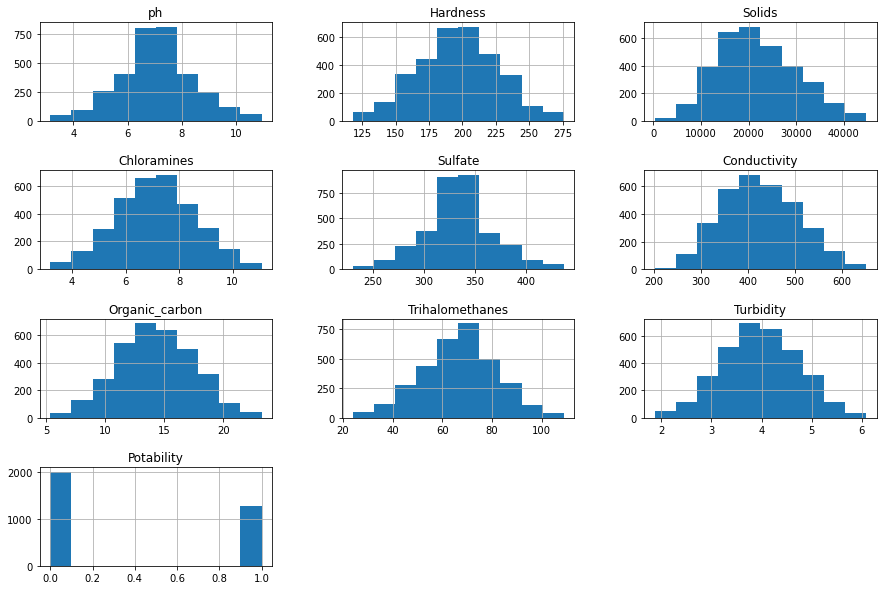

In [76]:
#now a look at the distributions of the features
water.hist(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)

In [77]:
#Our imputation has clearly increased the number of values around the median for certain features. That aside, we seem to have 
#workable features now: our data types are correct, we have no concerning duplicates, we have dealt with outliers and we have
#no missing values.
%store water

Stored 'water' (DataFrame)
